# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f"There are {azdias.shape[0]} of rows and {azdias.shape[1]} number of columns in general demographics dataset")
print(f"There are {feat_info.shape[0]} of rows and {feat_info.shape[1]} number of columns in feature summary file")

There are 891221 of rows and 85 number of columns in general demographics dataset
There are 85 of rows and 4 number of columns in feature summary file


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Let us see the info about the general demographics data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

One can see that the dataframe consists of 85 columns and some of the columns have null values.

In [6]:
# How many and which columns have null values
azdias.loc[:, azdias.isna().any()].columns

Index(['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SOHO_KZ',
       'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP',
       'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
       'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB'],
      dtype='object')

In [7]:
print(f"Out of 85 columns, {len(azdias.loc[:, azdias.isna().any()].columns)} columns have null values present")

Out of 85 columns, 53 columns have null values present


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


The `missing_or_unknown` column in above dataframe seems to hold the missing or unknown value codes in form of list.

In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


`feat_info` dataframe do not have any missing values and all the columns are of type `object` (or string)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Before moving onto the converting data points matching with `missing or unkonwn` codes let's find out first the
# naturally missing data per column.

compare_columns = azdias.isnull().sum().to_frame().reset_index()
compare_columns.columns = ['column_name','naturally_missing_count']
compare_columns

,column_name,naturally_missing_count
0,AGER_TYP,0
1,ALTERSKATEGORIE_GROB,0
2,ANREDE_KZ,0
3,CJT_GESAMTTYP,4854
4,FINANZ_MINIMALIST,0
5,FINANZ_SPARER,0
6,FINANZ_VORSORGER,0
7,FINANZ_ANLEGER,0
8,FINANZ_UNAUFFAELLIGER,0
9,FINANZ_HAUSBAUER,0


In [11]:
# Identify missing or unknown data values and convert them to NaNs.

# Let us take a look at feat_info dataframe
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


**Discussion**: One can see that, the `feat_info` dataframe has column `missing_or_unknown` which contains the codes for missing or unknown values in form of list. We need to replace the data in respective columns matching to those with codes in `missing_or_unknown` column by numpy nan value. One can see that some columns also has codes like "XX" or "X".

In [12]:
# Let us analyze one attribute from feat_info and compare it with azdias column values 
feat_info[feat_info['attribute']=='REGIOTYP']

,attribute,information_level,type,missing_or_unknown
73,REGIOTYP,region_rr1,ordinal,"[-1,0]"


In [13]:
azdias['REGIOTYP'].value_counts()

6.0    195286
5.0    145359
3.0     93929
2.0     91662
7.0     83943
4.0     68180
1.0     54798
0.0     36868
Name: REGIOTYP, dtype: int64

One can see that the there are 36868 entries with value as `0.0` (float), however the missing_or_unknown codes are int ([-1,0]) 

In [14]:
# Let us check if CAMEO_INTL_2015 column has "XX" code or not?
azdias[azdias['CAMEO_INTL_2015']=="XX"]['CAMEO_INTL_2015']

2511      XX
4569      XX
9803      XX
16700     XX
16883     XX
22386     XX
28123     XX
31618     XX
32864     XX
33666     XX
37159     XX
38692     XX
41518     XX
44762     XX
44966     XX
46810     XX
55863     XX
59397     XX
59418     XX
65660     XX
65665     XX
66373     XX
66478     XX
70996     XX
78154     XX
78255     XX
79427     XX
84000     XX
85928     XX
89753     XX
          ..
810900    XX
812183    XX
814262    XX
814284    XX
818352    XX
821084    XX
822877    XX
823875    XX
830322    XX
831345    XX
831447    XX
833151    XX
834195    XX
834724    XX
836551    XX
839958    XX
845051    XX
845388    XX
849433    XX
850517    XX
854777    XX
856970    XX
856991    XX
858229    XX
862516    XX
868148    XX
874917    XX
882189    XX
882231    XX
884998    XX
Name: CAMEO_INTL_2015, Length: 373, dtype: object

We can see that, CAMEO_INTL_2015 column has 373 entries with "XX" codes.

In [15]:
# Let us parse the feat_info dataframe's "missing_or_unknown" column before converting it into float values
float_missing = []
for missing_list in feat_info['missing_or_unknown']:
    float_missing.append(missing_list[1:-1].split(','))
float_missing

[['-1', '0'],
 ['-1', '0', '9'],
 ['-1', '0'],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['0'],
 [''],
 [''],
 ['-1', '0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['-1', '0'],
 ['-1', '0'],
 ['0'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1'],
 ['-1', '9'],
 ['0'],
 [''],
 [''],
 ['-1', '0'],
 ['-1'],
 ['-1', '0'],
 ['-1', '0'],
 ['0'],
 [''],
 ['-1', '0'],
 [''],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1', 'X'],
 ['XX'],
 ['-1', 'XX'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1', '0'],
 ['-1'],
 ['-1'],
 ['-1'],
 [''],
 ['-1', '0'],
 [''],
 [''],
 ['-1', '0'],
 [''],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1'],
 ['-1'],
 ['-1', '9'],
 ['-1', '0'],
 ['-1', '9']]

In [16]:
# we can't convert the empty ('') or "XX" and "X" to float so we need to avoid them while converting.
for i in range(len(float_missing)):
    for j in range(len(float_missing[i])):
        if float_missing[i][j]=="" or float_missing[i][j]=="XX" or float_missing[i][j]=="X":
            pass
        else:
            float_missing[i][j] = float(float_missing[i][j])
float_missing

[[-1.0, 0.0],
 [-1.0, 0.0, 9.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 9.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [''],
 [-1.0, 0.0],
 [''],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0, 'X'],
 ['XX'],
 [-1.0, 'XX'],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [''],
 [-1.0, 0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [''],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0, 9.0],
 [-1.0, 0.0],
 [-1.0, 9.0]]

In [17]:
# Function for replacing the missing codes by np.nan
def replace_by_nan(x, missing_codes):
    if x in missing_codes:
        return np.nan
    else:
        return x

In [18]:
# let us replace the values in respective columns by missing value codes. 
df = azdias.copy() # make copy of original dataframe into other for further usage.
for column, codes in zip(feat_info['attribute'], float_missing):
    df[column] = df[column].apply(replace_by_nan, missing_codes = codes)
    #print(codes[1:-1].split(','))
# sanity check
df['CAMEO_INTL_2015'][2511]

nan

In [19]:
df['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [20]:
# sanity check
df['REGIOTYP'].value_counts()

6.0    195286
5.0    145359
3.0     93929
2.0     91662
7.0     83943
4.0     68180
1.0     54798
Name: REGIOTYP, dtype: int64

One can see that the missing or unknown codes are replaced correctly by np.nan

In [21]:
df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
df.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [23]:
# Let us update the compare column to see the changes after replacement
compare_columns['count_after_replacing_codes'] = df.isnull().sum().values
compare_columns

,column_name,naturally_missing_count,count_after_replacing_codes
0,AGER_TYP,0,685843
1,ALTERSKATEGORIE_GROB,0,2881
2,ANREDE_KZ,0,0
3,CJT_GESAMTTYP,4854,4854
4,FINANZ_MINIMALIST,0,0
5,FINANZ_SPARER,0,0
6,FINANZ_VORSORGER,0,0
7,FINANZ_ANLEGER,0,0
8,FINANZ_UNAUFFAELLIGER,0,0
9,FINANZ_HAUSBAUER,0,0


**Discussions:** One can see that there are some columns where missing value count is much different than the naturally missing count for example see the column `AGER_TYP`

In [24]:
# For how many columns the natually missing count differs from the replacement count?
compare_columns[compare_columns['naturally_missing_count']!=compare_columns['count_after_replacing_codes']]

,column_name,naturally_missing_count,count_after_replacing_codes
0,AGER_TYP,0,685843
1,ALTERSKATEGORIE_GROB,0,2881
11,GEBURTSJAHR,0,392318
14,HEALTH_TYP,0,111196
15,LP_LEBENSPHASE_FEIN,4854,97632
16,LP_LEBENSPHASE_GROB,4854,94572
17,LP_FAMILIE_FEIN,4854,77792
18,LP_FAMILIE_GROB,4854,77792
21,NATIONALITAET_KZ,0,108315
22,PRAEGENDE_JUGENDJAHRE,0,108164


In [25]:
compare_columns[compare_columns['naturally_missing_count']!=compare_columns['count_after_replacing_codes']].shape[0]

25

So there 25 columns for which the natually missing count differs from the replacement count

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [26]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# 1) How much missing data is present in each column (percentage)
df_missing = ((df.isnull().sum()*100)/len(df)).to_frame()
df_missing.columns = ['percentage_missing']
df_missing = df_missing.sort_values(by='percentage_missing', ascending=False)
df_missing

,percentage_missing
TITEL_KZ,99.757636
AGER_TYP,76.955435
KK_KUNDENTYP,65.596749
KBA05_BAUMAX,53.468668
GEBURTSJAHR,44.020282
ALTER_HH,34.813699
KKK,17.735668
REGIOTYP,17.735668
W_KEIT_KIND_HH,16.605084
KBA05_ANTG1,14.959701


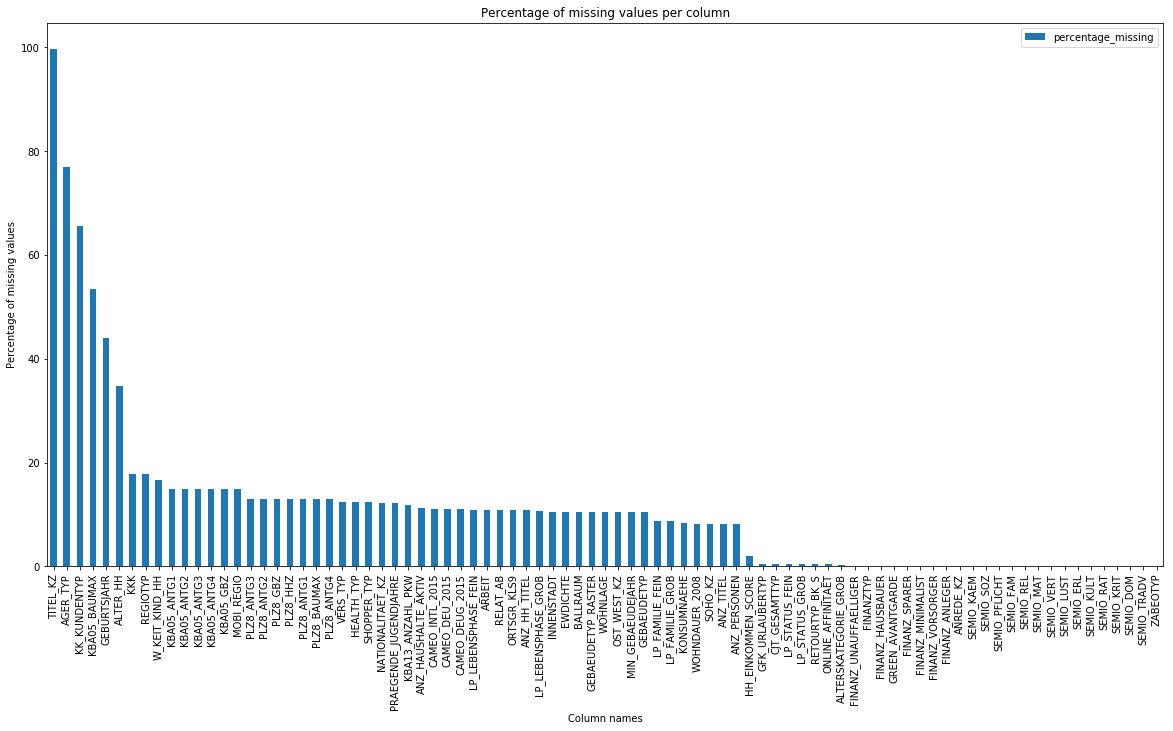

In [27]:
# Investigate patterns in the amount of missing data in each column.

df_missing.plot.bar(figsize=(20,10))
plt.xlabel("Column names")
plt.ylabel("Percentage of missing values")
plt.title("Percentage of missing values per column");

One can observe 6 columns having more than 20% missing values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ade4187f0>]], dtype=object)

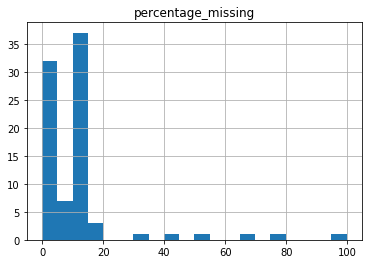

In [28]:
# Using hist() function to visualize the distribution of missing value counts to find outlier columns.
df_missing.hist(bins=20)

We can see outliers appearing after 20%, 6 such peaks are observed let us see how many columns have more than 20% of outliers present. Those columns we will drop by considering them as outliers.

In [29]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

df_missing[df_missing['percentage_missing']>20]

,percentage_missing
TITEL_KZ,99.757636
AGER_TYP,76.955435
KK_KUNDENTYP,65.596749
KBA05_BAUMAX,53.468668
GEBURTSJAHR,44.020282
ALTER_HH,34.813699


In [30]:
# Find names of the outlier columns 
drop_columns_list = df_missing[df_missing['percentage_missing']>20].index
drop_columns_list = list(drop_columns_list)
drop_columns_list

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [31]:
# drop the outlier columns
df = df.drop(columns=drop_columns_list)
df.shape

(891221, 79)

In [32]:
# Required when dealing with the Customers dataset
ref_dataframe = df.copy()

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram, one can see that the columns having more than 20% missing values are appearing to be different than those below 20%. Also, from the barplot, one can see that there are 6 columns with more than 20% missing values. These columns are considered to be outliers and are dropped form the dataframe before further analysis.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [33]:
# How much data is missing in each row of the dataset?
row_missing = df.isnull().sum(axis=1)
row_missing_df = pd.DataFrame(data=row_missing, columns=['no_missing_values'])
row_missing_df = row_missing_df.sort_values(by='no_missing_values', ascending=False)
row_missing_df

,no_missing_values
732775,49
643174,49
472919,48
345274,47
299868,47
582092,47
681255,47
818343,47
582109,47
439981,47


Text(0.5,1,'histogram plot for analysis of missing values in rows')

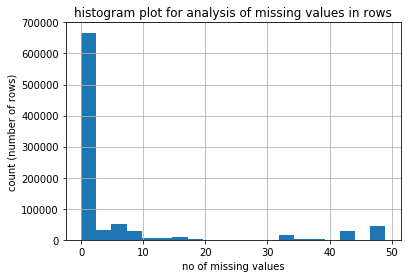

In [34]:
# Let us see the distribution of missing values for all the rows
row_missing_df.hist(bins=20)
plt.xlabel('no of missing values')
plt.ylabel('count (number of rows)')
plt.title('histogram plot for analysis of missing values in rows')

One can see that there are 2 groups in terms of number of missing values in rows. One group has less than 30 (<30) missing values where as other group has more than 30 missing values.

In [35]:
row_missing_df.describe()

,no_missing_values
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


One can see that 75% of the number of rows have upto 3 missing values. Maximum number of missing values is 49.

In [36]:
# How many rows have 49 missing values
row_missing_df[row_missing_df['no_missing_values']==49]

,no_missing_values
732775,49
643174,49


Only 2 rows have 49 missing values.

In [37]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_missing_subset = df[row_missing_df['no_missing_values']<30].reset_index(drop=True)
many_missing_subset = df[row_missing_df['no_missing_values']>=30].reset_index(drop=True)

print(f"shape of few missing subset is {few_missing_subset.shape}")
print(f"shape of many missing subset is {many_missing_subset.shape}")


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


shape of few missing subset is (798061, 79)
shape of many missing subset is (93160, 79)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [38]:
few_missing_subset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [39]:
# How much percentage is few missing and many missing subsets?
print(f"few_missing_subset covers {few_missing_subset.shape[0]*100/df.shape[0]}% of the total rows.")
print(f"many_missing_subset covers {many_missing_subset.shape[0]*100/df.shape[0]}% of the total rows.")

few_missing_subset covers 89.5469249490306% of the total rows.
many_missing_subset covers 10.453075050969401% of the total rows.


In [40]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# First let us find out 5 columns with no or few missing values
columns_without_missing_values = compare_columns[compare_columns['count_after_replacing_codes']==0]
columns_without_missing_values = list(columns_without_missing_values['column_name'])
columns_without_missing_values

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [41]:
columns_for_comarison = columns_without_missing_values[:6]
columns_for_comarison

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER']

In [42]:
def compare_few_missing_subset_with_many_missing_subset(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(4)

    ax1.set_title('Distribution of values in few_missing_subset of rows')
    g1 = sns.countplot(df.loc[few_missing_subset.index,column],ax=ax1)
    g1.grid(True)

    
    ax2.set_title('Distribution of values in many_missing_subset of rows')
    g2 = sns.countplot(df.loc[many_missing_subset.index,column],ax=ax2)

    fig.suptitle(column)
    g2.grid(True)
    plt.show()

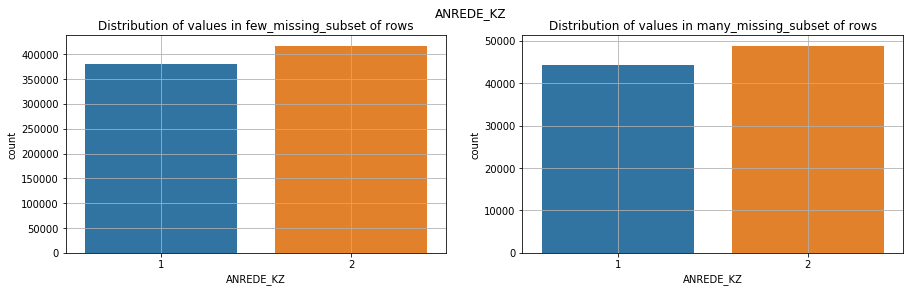

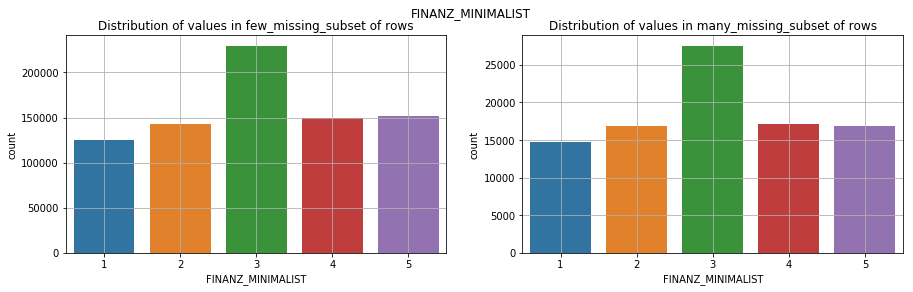

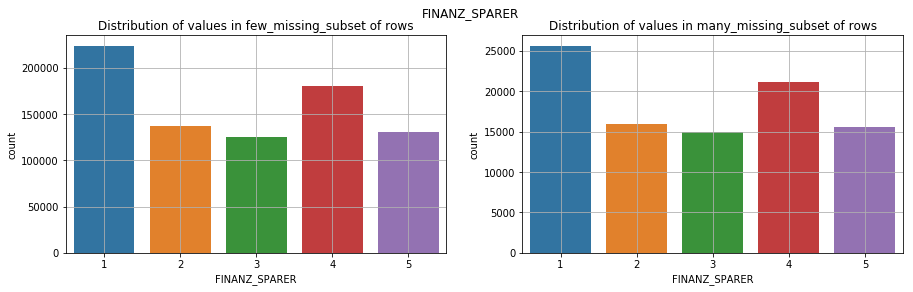

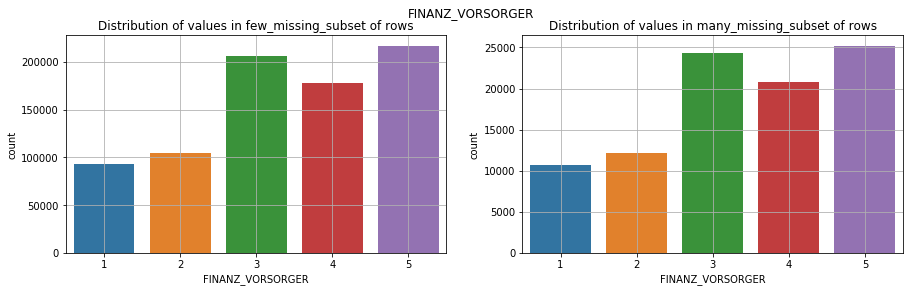

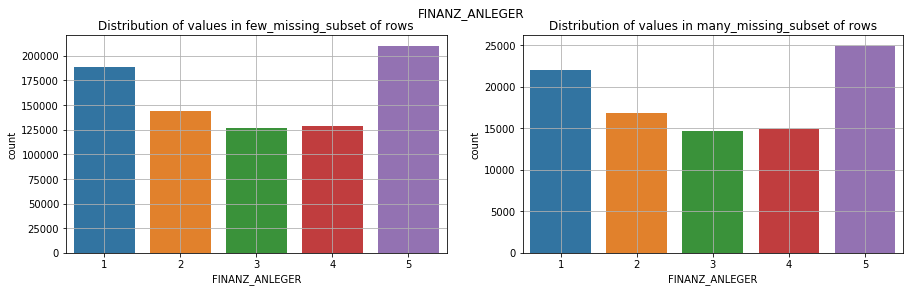

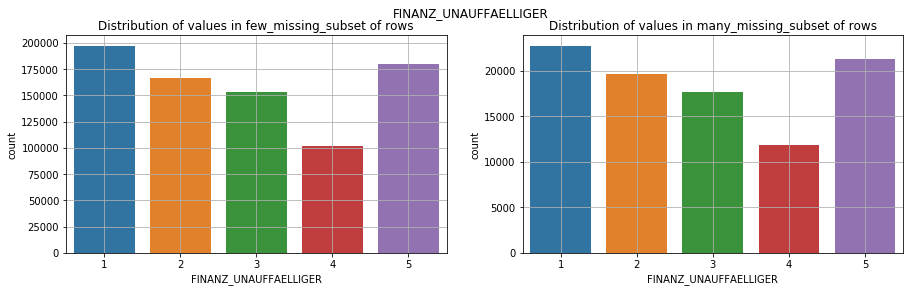

In [43]:
for column in columns_for_comarison:
    compare_few_missing_subset_with_many_missing_subset(column)

In [44]:
# Let us work only with the few_missing_subset only
df = df[~df.index.isin(many_missing_subset.index)]
df.shape

(798061, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The subplots of the histograms above clearly indicate that there is not a significant difference in terms of data distribution between the few or few many missing per row subsets. Take a clue from this, we can take a decision to drop the few missing subset rows (approx. 10.5 % of the total rows). By dropping this row, there would not be any impact in terms of significant information loss.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?

# How many features are there?
len(df.columns) # 79

79

In [46]:
feat_info_modified=feat_info[feat_info.attribute.isin(df.columns)]
feat_info_modified.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

There are 49 ordinal, 18 categorical, 6 mixed and 6 numeric features.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [47]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def find_binary_and_multilevel_categoricals(df,feature_information=feat_info):
    col_list = df.columns.tolist()
    
    cat_variables = feature_information.loc[feature_information['type'] == 'categorical', 'attribute'].values
    
    binary_categories=[]
    multi_level_categories=[]
    
    filtred_cat_var = list(set(cat_variables).intersection(set(col_list)))
    
    for col in filtred_cat_var:

        if df[col].nunique()==2:
            binary_categories.append(col)
        else:
            multi_level_categories.append(col)
    
    return binary_categories, multi_level_categories


In [48]:
# Re-encode categorical variable(s) to be kept in the analysis.

binary_categoricals, multi_level_categoricals = find_binary_and_multilevel_categoricals(df)
print("binary categorical variables: ", binary_categoricals)
print("multilevel categorical variables: ", multi_level_categoricals)

binary categorical variables:  ['SOHO_KZ', 'ANREDE_KZ', 'OST_WEST_KZ', 'VERS_TYP', 'GREEN_AVANTGARDE']
multilevel categorical variables:  ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'ZABEOTYP', 'SHOPPER_TYP', 'LP_FAMILIE_FEIN', 'NATIONALITAET_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'FINANZTYP', 'LP_STATUS_FEIN', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'GEBAEUDETYP']


In [49]:
# further inspect the variables
## inspecting binary variables
for bin_col in binary_categoricals:
    print(bin_col)
    print(df[bin_col].value_counts(), "\n")

SOHO_KZ
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64 

ANREDE_KZ
2    416483
1    381578
Name: ANREDE_KZ, dtype: int64 

OST_WEST_KZ
W    562845
O    152061
Name: OST_WEST_KZ, dtype: int64 

VERS_TYP
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64 

GREEN_AVANTGARDE
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64 



Except `GREEN_AVANTGARDE` other binary columns need re-encoding.

In [50]:
df["ANREDE_KZ"].replace({2.0:0,1.0:1},inplace=True)
df["VERS_TYP"].replace({2.0:0,1.0:1},inplace=True)
df["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
df["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)

In [51]:
# Observe the multicategory features
for multicat_col in multi_level_categoricals:
    print(multicat_col)
    print(df[multicat_col].value_counts(), "\n")

LP_FAMILIE_GROB
1.0    381733
5.0    179866
2.0     93416
4.0     47475
3.0     26203
Name: LP_FAMILIE_GROB, dtype: int64 

LP_STATUS_GROB
1.0    301581
2.0    202736
4.0    146602
5.0    106033
3.0     36768
Name: LP_STATUS_GROB, dtype: int64 

ZABEOTYP
3    326170
4    188290
1    111189
5     76090
6     66558
2     29764
Name: ZABEOTYP, dtype: int64 

SHOPPER_TYP
1.0    228397
2.0    185506
3.0    170522
0.0    114474
Name: SHOPPER_TYP, dtype: int64 

LP_FAMILIE_FEIN
1.0     381733
10.0    123575
2.0      93416
11.0     46265
8.0      20771
7.0      18615
4.0      11057
5.0      10743
9.0      10026
6.0       8089
3.0       4403
Name: LP_FAMILIE_FEIN, dtype: int64 

NATIONALITAET_KZ
1.0    613034
2.0     58566
3.0     29868
Name: NATIONALITAET_KZ, dtype: int64 

CAMEO_DEUG_2015
8    120363
9     96668
6     94860
4     93211
3     77870
2     74779
7     69622
5     49572
1     32370
Name: CAMEO_DEUG_2015, dtype: int64 

CAMEO_DEU_2015
6B    50682
8A    46860
4C    42917
2D    3150

Looking at the multilevel categorical features, I decide to drop them from further analysis

In [52]:
df = df.drop(columns=multi_level_categoricals)

In [53]:
df.shape

(798061, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

I dropped the multi-level categorical features and re-encoded the binary categoricals to either 0 or 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

df['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_index()


1.0      19076
2.0       6743
3.0      49532
4.0      18359
5.0      77448
6.0      23038
7.0       3609
8.0     130583
9.0      29997
10.0     76666
11.0     32046
12.0     22019
13.0      5192
14.0    169114
15.0     38166
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [55]:
!cat Data_Dictionary.md

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [56]:
# Seperating the decade and movement as new features
# Map decade 
decade_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def map_decade(x):
    try:
        for key, array in decade_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [57]:
# Create decade column
df['PRAEGENDE_JUGENDJAHRE_dec'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)

# Create movement column
df['PRAEGENDE_JUGENDJAHRE_mov'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)


In [58]:
df.shape

(798061, 68)

In [59]:
df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

In [60]:
df.shape

(798061, 67)

In [61]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df['CAMEO_INTL_2015'].head()


93160    43
93161    15
93162    45
93163    54
93164    43
Name: CAMEO_INTL_2015, dtype: object

In [62]:
# Map wealth 
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

# Map life stage
def map_lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [63]:
# Create wealth column
df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(map_wealth)

# Create life stage column
df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(map_lifestage)

Since two new features are created, we drop the original column `CAMEO_INTL_2015`

In [64]:
df = df.drop(['CAMEO_INTL_2015'], axis=1)

In [65]:
df.shape

(798061, 68)

In [66]:
df_manual = df.copy()

#### Discussion 1.2.2: Engineer Mixed-Type Features

There were specifically two mixed features for creating more features namely `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` representing 'Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)' and 'German CAMEO: Wealth / Life Stage Typology, mapped to international code', respectively.

Based on the `Data Dictionary` provided two new features were created out of above columns and the original columns were dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [67]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

df.dtypes.value_counts()


float64    45
int64      23
dtype: int64

As of now, there no need of re-engineering task

In [68]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print('PRAEGENDE_JUGENDJAHRE' in df.columns)
print('CAMEO_INTL_2015' in df.columns)

False
False


One can see that, the dataframe only consists only numneric columns and the original mixed type of columns to be engineered are also not present.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
def clean_data(df, ref_col_list=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
           ref_col_list is used for future purpose
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for column, codes in zip(feat_info['attribute'], float_missing):
        df[column] = df[column].apply(replace_by_nan, missing_codes = codes)
    #print(df['CAMEO_INTL_2015'].value_counts())
    # remove selected columns and rows, ...
    #------------------- Removing outlier columns ----------------------
    # 1) How much missing data is present in each column (percentage)
    df_missing = ((df.isnull().sum()*100)/len(df)).to_frame()
    df_missing.columns = ['percentage_missing']
    df_missing = df_missing.sort_values(by='percentage_missing', ascending=False)
    # Find names of the outlier columns 
    drop_columns_list = df_missing[df_missing['percentage_missing']>20].index
    drop_columns_list = list(drop_columns_list)
    ref_col_list = ref_col_list or []
    final_drop_columns=[col for col in drop_columns_list if col not in ref_col_list]
    # Drop the outlier columns
    df = df.drop(columns=final_drop_columns)
    # ------------------- Removing Rows ------------------------------
    # How much data is missing in each row of the dataset?
    row_missing = df.isnull().sum(axis=1)
    row_missing_df = pd.DataFrame(data=row_missing, columns=['no_missing_values'])
    row_missing_df = row_missing_df.sort_values(by='no_missing_values', ascending=False)
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    few_missing_subset = df[row_missing_df['no_missing_values']<30].reset_index(drop=True)
    many_missing_subset = df[row_missing_df['no_missing_values']>=30].reset_index(drop=True)
    # Let us work only with the few_missing_subset only
    df = df[~df.index.isin(many_missing_subset.index)]

    # select, re-encode, and engineer column values.
    binary_categoricals, multi_level_categoricals = find_binary_and_multilevel_categoricals(df)
    df = df.drop(columns=multi_level_categoricals)
    
    df_col_list=df.columns.tolist()
    
    if 'ANREDE_KZ' in df_col_list:
        df["ANREDE_KZ"].replace({2.0:0,1.0:1},inplace=True)
    if 'VERS_TYP' in df_col_list:
        df["VERS_TYP"].replace({2.0:0,1.0:1},inplace=True)
    if "SOHO_KZ" in df_col_list:
        df["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    if "OST_WEST_KZ" in df_col_list:
        df["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
        
    if "PRAEGENDE_JUGENDJAHRE" in df_col_list:
        # Create decade column
        df['PRAEGENDE_JUGENDJAHRE_dec'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
        # Create movement column
        df['PRAEGENDE_JUGENDJAHRE_mov'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
        df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    if 'CAMEO_INTL_2015' in df_col_list:
        # Create wealth column
        df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(map_wealth)
        # Create life stage column
        df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(map_lifestage)
        df = df.drop(['CAMEO_INTL_2015'], axis=1)

    # Return the cleaned dataframe.
    return df
    

In [70]:
# Read general demographics data again to test the clean_data function
df_gen = pd.read_csv ('Udacity_AZDIAS_Subset.csv', sep = ';')
df_gen.shape

(891221, 85)

In [71]:
# Test the cleaning function..the output should be (798061, 68)
df_cleaned = clean_data(df_gen)
df_cleaned.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(798061, 68)

In [72]:
# Code to check the written clean_data function
assert df_cleaned.shape[0] == df_manual.shape[0], "clean_data function is not working properly, rows mismatch"
assert df_cleaned.shape[1] == df_manual.shape[1], "clean_data function is not working properly, columns mismatch"
print("The cleaning function is working as expected..")

The cleaning function is working as expected..


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Since NaN treatment is not done earlier doing the same here.
# imputing NaN 
col_list=df_cleaned.columns.tolist()
imputer = Imputer(strategy='mean', axis=0)
df_cleaned = imputer.fit_transform(df_cleaned)
df_cleaned = pd.DataFrame(df_cleaned, columns=col_list)
df_cleaned.isnull().sum()

ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP                   0
LP_LEBENSPHASE_FEIN          0
LP_LEBENSPHASE_GROB          0
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                     0
ANZ_PERSONEN                 0
                            ..
OST_WEST_KZ                  0
WOHNLAGE

The np.nan values are replaced by the imputed means in the respective columns

In [74]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_cleaned)
scaled_df = pd.DataFrame(scaled_df, columns= col_list)
scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_dec,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,1.231412,-0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.268112,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.052862,-0.832891,-1.703722,-0.682527,0.536028,0.089457
1,0.240123,1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,1.146826,...,-0.692964,0.427850,-0.367319,0.882833,1.245454,-0.054110,-0.973237,1.465143,-1.636902,1.518387
2,0.240123,-0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,1.146826,...,-0.692964,-1.774003,-0.367319,-0.176995,-0.593198,-0.832891,-0.242752,-0.682527,0.536028,1.518387
3,-0.751165,1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,1.146826,...,0.777350,0.427850,-0.367319,0.882833,-0.133535,-0.054110,1.218218,-0.682527,1.260338,0.803922
4,-0.751165,-0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.683050,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.972188,-0.832891,1.218218,-0.682527,0.536028,0.089457


### Discussion 2.1: Apply Feature Scaling

I used Imputing strategy along the columns for replacing the NaNs by mean, then I applied the `StandardScaler` to scale the dataset to have mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(scaled_df)
df_pca = pd.DataFrame(pca_features, columns = ["PrinComp-"+str(i) for i in range(len(scaled_df.columns))])
df_pca.head()

,PrinComp-0,PrinComp-1,PrinComp-2,PrinComp-3,PrinComp-4,PrinComp-5,PrinComp-6,PrinComp-7,PrinComp-8,PrinComp-9,...,PrinComp-58,PrinComp-59,PrinComp-60,PrinComp-61,PrinComp-62,PrinComp-63,PrinComp-64,PrinComp-65,PrinComp-66,PrinComp-67
0,-2.725227,4.058069,-1.123089,-1.247823,1.105708,-1.949316,0.931523,-2.094645,-0.062964,-0.383330,...,-0.017341,0.156196,0.024715,-0.599391,0.530696,0.152981,-0.238498,-0.010786,-0.176208,-0.024573
1,-2.214966,2.478557,2.190912,3.394488,0.202224,-2.504154,-0.924630,2.506131,0.869292,-0.047385,...,0.148274,0.141735,0.078993,0.378861,0.010680,-0.080639,0.043876,0.000669,-0.097472,0.109439
2,-4.051317,-0.466617,-2.464246,-0.492608,4.648854,-0.147271,0.382063,0.269486,2.579733,-0.924514,...,0.693976,0.140923,0.518469,0.071282,0.508879,-0.870957,-0.514308,0.014567,0.051985,-0.188364
3,4.697832,-3.238270,2.757530,-1.477077,-1.268849,-0.155472,-0.707709,-3.681738,-0.612448,-1.056554,...,0.556717,-0.456503,0.037333,-0.013923,0.167196,-0.519705,0.368012,-0.425669,-0.185081,-0.091951
4,-1.631261,-3.779048,-2.827128,-4.173199,1.023668,-2.488003,1.102327,-0.771806,-1.126680,2.188351,...,0.026300,0.198037,0.222327,0.157177,-0.092155,-0.335586,-0.557508,-0.389782,-0.276020,-0.051940


In [76]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_


array([  1.69252416e-01,   1.23086148e-01,   8.69797961e-02,
         5.31851885e-02,   4.04478440e-02,   3.28130514e-02,
         3.04294956e-02,   2.54402630e-02,   2.42968716e-02,
         2.19689069e-02,   2.08400367e-02,   2.00534847e-02,
         1.87685230e-02,   1.77681951e-02,   1.74947364e-02,
         1.56442009e-02,   1.47060479e-02,   1.43427007e-02,
         1.34009435e-02,   1.23895196e-02,   1.18069549e-02,
         1.14161848e-02,   1.12672864e-02,   1.08195864e-02,
         1.05949857e-02,   9.57628673e-03,   9.41118018e-03,
         8.38383345e-03,   7.49985110e-03,   7.16350413e-03,
         6.90052937e-03,   6.69105184e-03,   6.46914435e-03,
         6.24990946e-03,   6.09256142e-03,   5.83308022e-03,
         5.59559402e-03,   5.23132802e-03,   4.70208444e-03,
         4.46593362e-03,   4.36313789e-03,   4.05315613e-03,
         3.98734747e-03,   3.82515338e-03,   3.65944523e-03,
         3.64523619e-03,   3.47265893e-03,   3.36290035e-03,
         3.13797534e-03,

In [77]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.16925242,  0.29233856,  0.37931836,  0.43250355,  0.47295139,
        0.50576444,  0.53619394,  0.5616342 ,  0.58593107,  0.60789998,
        0.62874002,  0.6487935 ,  0.66756203,  0.68533022,  0.70282496,
        0.71846916,  0.73317521,  0.74751791,  0.76091885,  0.77330837,
        0.78511532,  0.79653151,  0.8077988 ,  0.81861838,  0.82921337,
        0.83878965,  0.84820083,  0.85658467,  0.86408452,  0.87124802,
        0.87814855,  0.8848396 ,  0.89130875,  0.89755866,  0.90365122,
        0.9094843 ,  0.91507989,  0.92031122,  0.92501331,  0.92947924,
        0.93384238,  0.93789553,  0.94188288,  0.94570804,  0.94936748,
        0.95301272,  0.95648538,  0.95984828,  0.96298625,  0.9659546 ,
        0.96888911,  0.97163037,  0.9742137 ,  0.97673678,  0.9791595 ,
        0.98152954,  0.9838122 ,  0.9859557 ,  0.98799997,  0.98987727,
        0.99168207,  0.99343546,  0.99502204,  0.99652811,  0.9977217 ,
        0.99888884,  0.99989042,  1.        ])

In [78]:
df_ExpVar = pd.DataFrame({'prin_comp_num':[i for i in range(len(scaled_df.columns))], 'cumulative_expl_var (%)':np.cumsum(pca.explained_variance_ratio_)*100})
df_ExpVar

,prin_comp_num,cumulative_expl_var (%)
0,0,16.925242
1,1,29.233856
2,2,37.931836
3,3,43.250355
4,4,47.295139
5,5,50.576444
6,6,53.619394
7,7,56.163420
8,8,58.593107
9,9,60.789998


One can see that 22 components combiningly explain 80% of the variance, where as 27 components explain 85% of the variance.

In [79]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.grid(True)

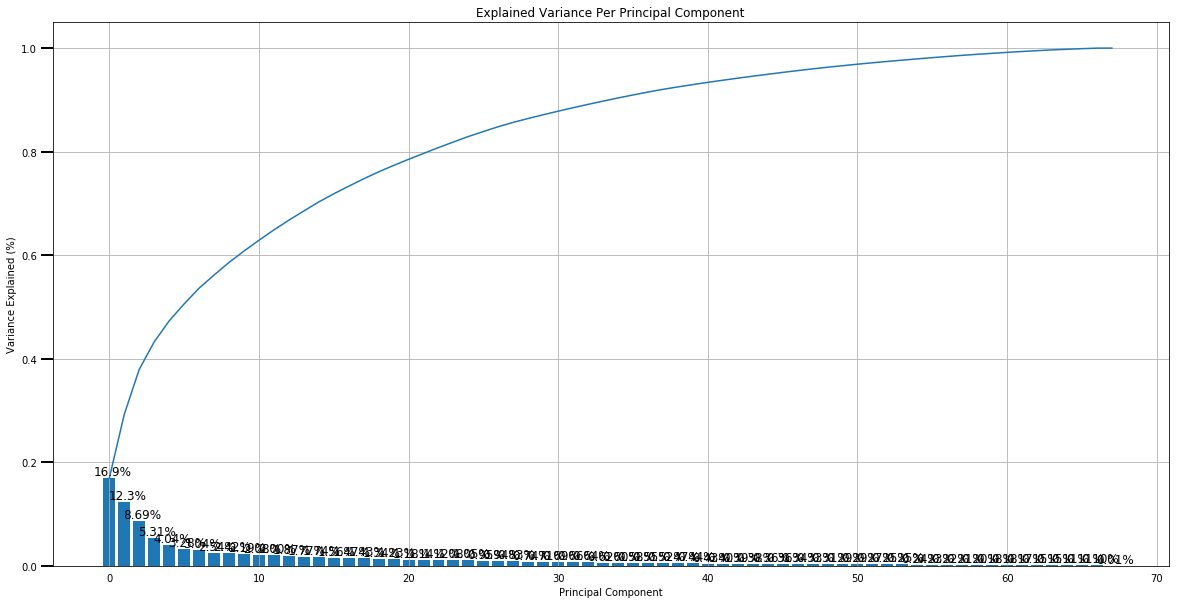

In [80]:
scree_plot(pca)

Taking the cue from scree plot and cumulative explained variance ratio, I decide to select the 27 principal components in order to perform the dimensional reduction step.

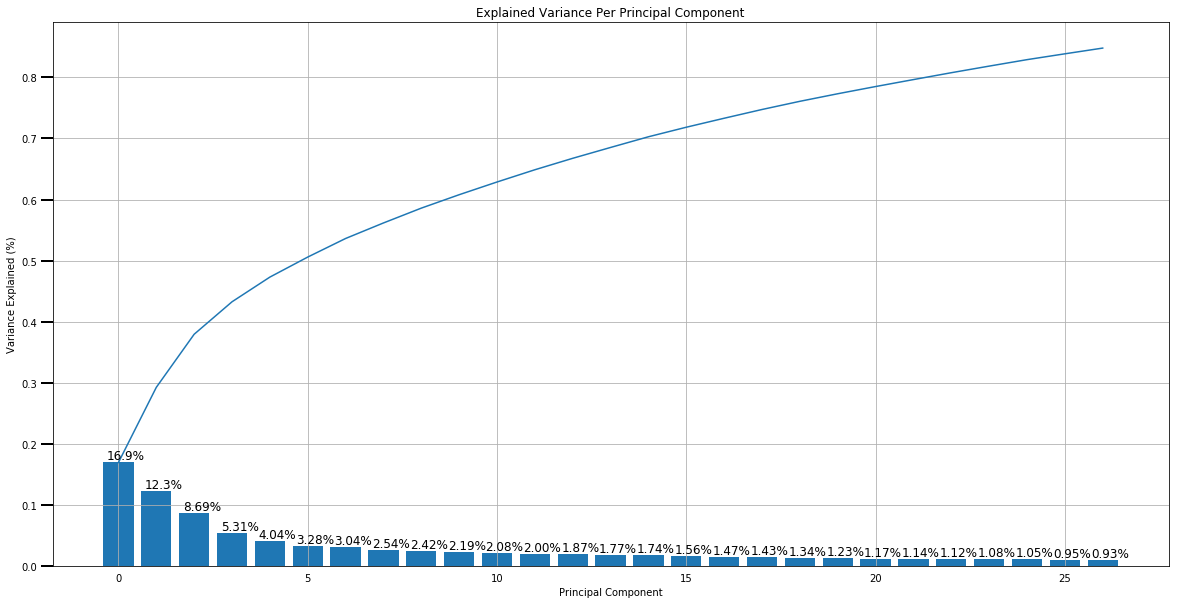

In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(27)
final_pca_features = pca.fit_transform(scaled_df)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Using `PCA` class in sklearn library, I applied the `fit_transform` method with specifying the number of components which gave the total of 68 principal components which combiningly expalain the 100% of the variance. Using the scree plot, I got to know that in my case 22 components explained 80% of the variance while 27 components explained 85% of the variance. I decided to go with 27 components and refitted the PCA with these many components for further analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# let us create a function that gives the feature weights for the ith component

In [83]:
def get_sorted_comp_feature_weights(pca, scaled_df, comp_number, top_k=5):
    """
    This function returns set of top_k sorted positive and negative features for the ith principal
    component of the pca.
    
    Args:
    pca: PCA object
    scaled_dataframe: the dataframe on which PCA was applied
    comp_number: Principal component number to be analyzed.
    top_k: integer representing the number of positive and negative features 
    
    Returns:
    positive_features: dictionary representing top_k positive features and corresponding weights
    negative_features: dictionary representing top_k negative features and corresponding weights
    """
    df_comp_feat = pd.DataFrame(data=pca.components_, columns = scaled_df.columns)
    df_comp_feat.index = ['PrinComp-'+str(i) for i in range(pca.components_.shape[0])]
    sorted_ith_comp_data = df_comp_feat.iloc[comp_number].sort_values(ascending=False)
    positive_features = sorted_ith_comp_data[:top_k].to_dict()
    negative_features = sorted_ith_comp_data[-top_k:].to_dict()
    return positive_features, negative_features

In [84]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# Set k value as 5
k= 5
# Set the value for first principal component
c_num = 0
comp0_positive, comp0_negative = get_sorted_comp_feature_weights(pca, scaled_df, comp_number=c_num, top_k=k)
print(f"Top {k} positive feature names corresponding to principal component-{c_num} are: \n {comp0_positive}")
print(f"Top {k} negative feature names corresponding to principal component-{c_num} are: \n {comp0_negative}")

Top 5 positive feature names corresponding to principal component-0 are: 
 {'PLZ8_ANTG3': 0.2299681116710817, 'PLZ8_ANTG4': 0.22408382789583517, 'PLZ8_BAUMAX': 0.21930867503270385, 'ORTSGR_KLS9': 0.20346971574533973, 'CAMEO_INTL_2015_wealth': 0.2031522741154166}
Top 5 negative feature names corresponding to principal component-0 are: 
 {'FINANZ_MINIMALIST': -0.19589103272929856, 'KBA05_GBZ': -0.21531767224762927, 'KBA05_ANTG1': -0.22196694202253484, 'PLZ8_ANTG1': -0.22898433442773428, 'MOBI_REGIO': -0.23957231691944209}


In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Set k value as 5
k= 5
# Set the value for first principal component
c_num = 1
comp0_positive, comp0_negative = get_sorted_comp_feature_weights(pca, scaled_df, comp_number=c_num, top_k=k)
print(f"Top {k} positive feature names corresponding to principal component-{c_num} are: \n {comp0_positive}")
print(f"Top {k} negative feature names corresponding to principal component-{c_num} are: \n {comp0_negative}")

Top 5 positive feature names corresponding to principal component-1 are: 
 {'ALTERSKATEGORIE_GROB': 0.2795811900299012, 'FINANZ_VORSORGER': 0.25936505712307256, 'SEMIO_ERL': 0.22901632710234243, 'SEMIO_LUST': 0.19000872964782745, 'RETOURTYP_BK_S': 0.17216817251248667}
Top 5 negative feature names corresponding to principal component-1 are: 
 {'FINANZ_UNAUFFAELLIGER': -0.24420914285274062, 'SEMIO_PFLICHT': -0.25338203295146794, 'SEMIO_REL': -0.2607742386308664, 'FINANZ_SPARER': -0.2696243714610699, 'PRAEGENDE_JUGENDJAHRE_dec': -0.27145212077085495}


In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Set k value as 5
k= 5
# Set the value for first principal component
c_num = 2
comp0_positive, comp0_negative = get_sorted_comp_feature_weights(pca, scaled_df, comp_number=c_num, top_k=k)
print(f"Top {k} positive feature names corresponding to principal component-{c_num} are: \n {comp0_positive}")
print(f"Top {k} negative feature names corresponding to principal component-{c_num} are: \n {comp0_negative}")

Top 5 positive feature names corresponding to principal component-2 are: 
 {'ANREDE_KZ': 0.3633801902579988, 'SEMIO_VERT': 0.3557503265216886, 'SEMIO_SOZ': 0.29048299941562544, 'SEMIO_KULT': 0.283132243873953, 'SEMIO_FAM': 0.2368836737623184}
Top 5 negative feature names corresponding to principal component-2 are: 
 {'SEMIO_ERL': -0.18196473411218056, 'SEMIO_RAT': -0.18258883833466077, 'SEMIO_KRIT': -0.3090424328132657, 'SEMIO_DOM': -0.3361116791972442, 'SEMIO_KAEM': -0.36319108020373897}


### Discussion 2.3: Interpret Principal Components

##### Positive features explanation for first principal component
| Feature                | Weight | Description                                                 |
| ---------------------- | ------ | ----------------------------------------------------------- |
| PLZ8_ANTG3             | 0.2300 | Number of 6-10 family houses in the PLZ8 region             |
| PLZ8_ANTG4             | 0.2241 | Number of 10+ family houses in the PLZ8 region              |
| PLZ8_BAUMAX            | 0.2193 | Most common building type within the PLZ8 region            |
| ORTSGR_KLS9            | 0.2035 | Size of community                                           |
| CAMEO_INTL_2015_wealth | 0.2032 | German CAMEO: Wealth Typology, mapped to international code |

##### Negative features explanation for first principal component
| Feature           | Weight  | Description                                             |
| ----------------- | ------- | ------------------------------------------------------- |
| FINANZ_MINIMALIST | -0.1959 | Financial typology - MINIMALIST: low financial interest |
| KBA05_GBZ         | -0.2153 | Number of buildings in the microcell                    |
| KBA05_ANTG1       | -0.2220 | Number of 1-2 family houses in the microcell            |
| PLZ8_ANTG1        | -0.2290 | Number of 1-2 family houses in the PLZ8 region          |
| MOBI_REGIO        | -0.2396 | Movement patterns                                       |

##### Positive features explanation for the second principal component
| Feature              | Weight | Description                                 |
| -------------------- | ------ | ------------------------------------------- |
| ALTERSKATEGORIE_GROB | 0.2796 | Estimated age based on given name analysis  |
| FINANZ_VORSORGER     | 0.2594 | Financial typology - VORSORGER: be prepared |
| SEMIO_ERL            | 0.2290 | Personality typology - ERL: event-oriented  |
| SEMIO_LUST           | 0.1900 | Personality typology - LUST: sensual-minded |
| RETOURTYP_BK_S       | 0.1722 | Return type                                 |

##### Negative features explanation for the second principal component
| Features                     | Weight  | Description                                        |
| ---------------------------- | ------- | -------------------------------------------------- |
| FINANZ_UNAUFFAELLIGER        | -0.2442 | Financial typology - UNAUFFAELLIGER: inconspicuous |
| SEMIO_PFLICHT                | -0.2534 | Personality typology - PFLICHT: dutiful            |
| SEMIO_REL                    | -0.2608 | Personality typology - REL: religious              |
| FINANZ_SPARER                | -0.2696 | Financial typology - SPARER: money-saver           |
| PRAEGENDE_JUGENDJAHRE_decade | -0.2714 | Dominating movement of person's youth (decade)     |

##### Positive features explanation for the third principal component
| Feature    | Weight | Description                                  |
| ---------- | ------ | -------------------------------------------- |
| ANREDE_KZ  | 0.3634 | Gender                                       |
| SEMIO_VERT | 0.3558 | Personality typology - VERT: dreamful        |
| SEMIO_SOZ  | 0.2905 | Personality typology - SOZ: socially-minded  |
| SEMIO_KULT | 0.2831 | Personality typology - KULT: cultural-minded |
| SEMIO_FAM  | 0.2369 | Personality typology - FAM: family-minded    |

##### Negative features explanation for the third pricipal component
| Feature    | Weight  | Description                                     |
| ---------- | ------- | ----------------------------------------------- |
| SEMIO_ERL  | -0.1819 | Personality typology - ERL: event-oriented      |
| SEMIO_RAT  | -0.1826 | Personality typology - RAT: rational            |
| SEMIO_KRIT | -0.3090 | Personality typology - KRIT: critical-minded    |
| SEMIO_DOM  | -0.3361 | Personality typology - DOM: dominant-minded     |
| SEMIO_KAEM | -0.3632 | Personality typology - KAEM: combative attitude |


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [87]:
#defining function that was given during the course.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data)) #absolute value taken
    
    return score

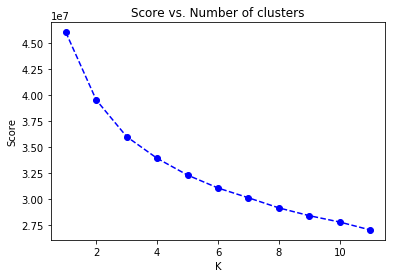

In [88]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
scores = []
centers = list(range(1,12))

for center in centers:
    scores.append(get_kmeans_score(final_pca_features, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');

Number of clusters as 5 seems a good choice

In [89]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


In [90]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans (n_clusters = 5) 

model = kmeans.fit (final_pca_features) #fitting to the data

labels_genpop = model.predict (final_pca_features) #returning array of indeces for the cluster each sample belongs to.


### Discussion 3.1: Apply Clustering to General Population

From the plot between number of clusters and score along with elbow method, one can see that 5 clusters seems a good choice  since from that change in the score is not very significant.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [91]:
# Load in the customer demographics data.
customers = pd.read_csv ('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [92]:
customers.shape

(191652, 85)

In [93]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers, ref_col_list=ref_dataframe.columns.tolist())
customers_cleaned.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_dec,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
49927,1.0,0,2,5,3,5,5,3,0,NaN,...,1.0,4.0,4.0,4.0,7.0,5.0,NaN,0,1.0,3.0
49928,3.0,0,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
49929,4.0,1,5,1,5,1,2,2,0,2.0,...,1.0,4.0,5.0,4.0,3.0,5.0,0.0,1,1.0,5.0
49930,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,4.0,4.0,3.0,6.0,2.0,1.0,0,1.0,5.0
49931,4.0,0,2,1,5,1,1,5,0,1.0,...,4.0,3.0,2.0,3.0,7.0,5.0,2.0,0,3.0,1.0


In [94]:
scaled_df.columns == customers_cleaned.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [95]:
# Performing imputation, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust_col_list=customers_cleaned.columns.tolist()
# Using the imputer object fitted on the general demographics data to transform the customers data
customers_cleaned = imputer.transform(customers_cleaned)
customers_cleaned = pd.DataFrame(customers_cleaned, columns=cust_col_list)
# Standardization
scaled_cutomers = scaler.transform(customers_cleaned)
# PCA
pca_customers = pca.transform(scaled_cutomers)
# K-Means clustering
labels_customers = model.predict(pca_customers)

In [96]:
genpop_clusters = pd.DataFrame(labels_genpop, columns=['cluster_label'])
cust_clusters = pd.DataFrame(labels_customers, columns=['cluster_label'])

# Create a new dataframes for plotting the proportions using histograms
genpop_prop = pd.DataFrame(genpop_clusters.groupby('cluster_label').size(), columns=['counts'])
customers_prop = pd.DataFrame(cust_clusters.groupby('cluster_label').size(), columns=['counts'])
genpop_prop.reset_index(inplace=True)
customers_prop.reset_index(inplace=True)
print("General population data proportions are: \n",genpop_prop)
print("Customers data proportions are: \n",customers_prop)

General population data proportions are: 
    cluster_label  counts
0              0  139302
1              1  170635
2              2  125439
3              3  199319
4              4  163366
Customers data proportions are: 
    cluster_label  counts
0              0   23125
1              1   36379
2              2    1984
3              3   59500
4              4   20737


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [97]:
def compare_plot(general,customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General Clusters')
    sns.countplot(general,ax=ax1)

    ax2.set_title('Customers Clusters')
    sns.countplot(customers,ax=ax2)
    plt.show()


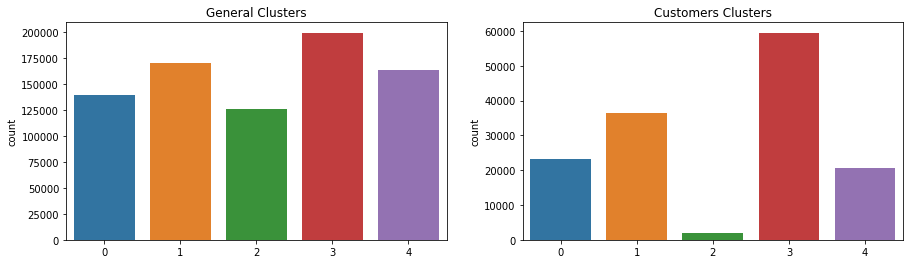

In [98]:
compare_plot(labels_genpop, labels_customers)

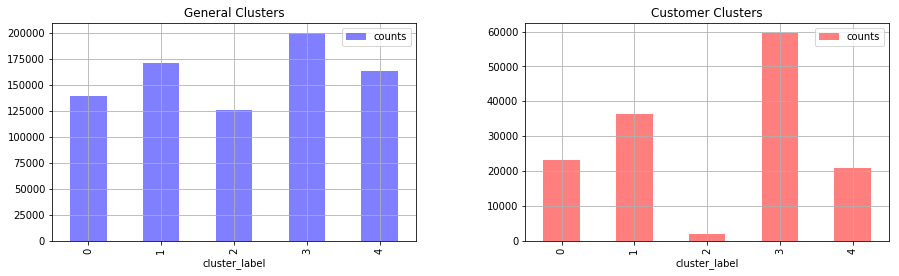

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharey=False)
figure.subplots_adjust(hspace = 1, wspace=.3)

p1 = genpop_prop.plot(kind='bar',x='cluster_label',y='counts',color='blue', ax=axs[0], alpha=0.5)
axs[0].set_title('General Clusters')
p1.grid(True)
p2 = customers_prop.plot(kind='bar',x='cluster_label',y='counts', ax=axs[1], color='red',alpha=0.5)
axs[1].set_title('Customer Clusters')
p2.grid(True)

In [100]:
# Get the percentage analysis for the above plot
compare_prop = genpop_prop.copy()
compare_prop.rename(columns = {'counts': 'genpop_counts'}, inplace = True)
compare_prop['cust_counts'] = customers_prop['counts']
compare_prop['percentage']= (compare_prop['cust_counts']/compare_prop['genpop_counts'])*100
compare_prop

,cluster_label,genpop_counts,cust_counts,percentage
0,0,139302,23125,16.600623
1,1,170635,36379,21.319776
2,2,125439,1984,1.581645
3,3,199319,59500,29.851645
4,4,163366,20737,12.693584


In [101]:
compare_pct = pd. DataFrame(columns=['cluster_label', 'genpop_pct', 'cust_pct'])
compare_pct['cluster_label'] = compare_prop['cluster_label']
compare_pct['genpop_pct'] = compare_prop['genpop_counts']*100/compare_prop['genpop_counts'].sum()
compare_pct['cust_pct'] = compare_prop['cust_counts']*100/compare_prop['cust_counts'].sum()
compare_pct['is_cust_gt_genpop'] = compare_pct['cust_pct']>compare_pct['genpop_pct']
compare_pct

,cluster_label,genpop_pct,cust_pct,is_cust_gt_genpop
0,0,17.455057,16.316811,False
1,1,21.381198,25.668725,True
2,2,15.717971,1.399894,False
3,3,24.975409,41.982713,True
4,4,20.470365,14.631857,False


There are two clusters, cluster with label 1 and cluster with label 3 where there is a higher proportion of persons for the customer data compared to the general population. Cluster with label 2 is clearly under-represented where as cluster with label 3 is over-represented.

In [116]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_over = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[3]))

In [117]:
centroid_over.shape

(68,)

In [118]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_under = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))

In [119]:
centroid_under.shape

(68,)

In [120]:
centroids=pd.DataFrame({"feature":customers_cleaned.columns,"cluster_over":centroid_over,"cluster_under":centroid_under})
centroids

,feature,cluster_over,cluster_under
0,ALTERSKATEGORIE_GROB,2.898674,1.779348
1,ANREDE_KZ,0.959721,0.594870
2,FINANZ_MINIMALIST,4.182938,1.613572
3,FINANZ_SPARER,2.339905,4.286942
4,FINANZ_VORSORGER,3.651416,2.187017
5,FINANZ_ANLEGER,2.431889,3.811979
6,FINANZ_UNAUFFAELLIGER,2.588662,3.695765
7,FINANZ_HAUSBAUER,2.091433,3.862688
8,GREEN_AVANTGARDE,0.340177,0.079514
9,HEALTH_TYP,2.200388,2.270465


In [122]:
# List of positive and negative features list based on top-3 principal component analysis done in section 2.3
positive_corr = ['PLZ8_ANTG3', 'PLZ8_ANTG4','PLZ8_BAUMAX','ORTSGR_KLS9','CAMEO_INTL_2015_wealth', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'SEMIO_ERL', 'SEMIO_LUST', 'RETOURTYP_BK_S', 'ANREDE_KZ', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_KULT', 'SEMIO_FAM']

negative_corr = ['FINANZ_MINIMALIST', 'KBA05_GBZ', 'KBA05_ANTG1','PLZ8_ANTG1', 'MOBI_REGIO', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_PFLICHT', 'SEMIO_REL', 'FINANZ_SPARER', 'PRAEGENDE_JUGENDJAHRE_dec', 'SEMIO_ERL', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM']

In [123]:
posfeat_df = centroids[centroids["feature"].isin(positive_corr)]
negfeat_df = centroids[centroids["feature"].isin(negative_corr)]

# Add the difference columns showing cluster_over - cluster_under
posfeat_df['diff'] = posfeat_df['cluster_over']-posfeat_df['cluster_under']
negfeat_df['diff'] = negfeat_df['cluster_over']-negfeat_df['cluster_under']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [124]:
# what kinds of people are typified by over-represented clusters having positive features
posfeat_df.sort_values(by='diff', ascending=False)

,feature,cluster_over,cluster_under,diff
17,SEMIO_VERT,6.095994,4.374418,1.721576
4,FINANZ_VORSORGER,3.651416,2.187017,1.464399
18,SEMIO_LUST,4.402694,2.979807,1.422887
0,ALTERSKATEGORIE_GROB,2.898674,1.779348,1.119326
12,RETOURTYP_BK_S,3.555955,2.727742,0.828213
19,SEMIO_ERL,3.673159,3.102952,0.570207
1,ANREDE_KZ,0.959721,0.594870,0.364851
13,SEMIO_SOZ,5.255646,5.112805,0.142841
14,SEMIO_FAM,5.285067,5.556059,-0.270992
20,SEMIO_KULT,5.347660,5.666827,-0.319166


In [125]:
# Get the sorted features by difference 
sorted_posfeat = posfeat_df.sort_values(by='diff', ascending=False)
sorted_negfeat = negfeat_df.sort_values(by='diff', ascending=False)
sorted_posfeat

,feature,cluster_over,cluster_under,diff
17,SEMIO_VERT,6.095994,4.374418,1.721576
4,FINANZ_VORSORGER,3.651416,2.187017,1.464399
18,SEMIO_LUST,4.402694,2.979807,1.422887
0,ALTERSKATEGORIE_GROB,2.898674,1.779348,1.119326
12,RETOURTYP_BK_S,3.555955,2.727742,0.828213
19,SEMIO_ERL,3.673159,3.102952,0.570207
1,ANREDE_KZ,0.959721,0.594870,0.364851
13,SEMIO_SOZ,5.255646,5.112805,0.142841
14,SEMIO_FAM,5.285067,5.556059,-0.270992
20,SEMIO_KULT,5.347660,5.666827,-0.319166


In [126]:
sorted_negfeat

,feature,cluster_over,cluster_under,diff
2,FINANZ_MINIMALIST,4.182938,1.613572,2.569366
50,MOBI_REGIO,3.869676,1.715420,2.154256
40,KBA05_ANTG1,2.332507,0.370323,1.962184
44,KBA05_GBZ,3.931936,2.127320,1.804617
54,PLZ8_ANTG1,2.811090,1.404856,1.406234
19,SEMIO_ERL,3.673159,3.102952,0.570207
22,SEMIO_KRIT,3.277449,3.956193,-0.678744
6,FINANZ_UNAUFFAELLIGER,2.588662,3.695765,-1.107103
23,SEMIO_DOM,3.070357,4.253252,-1.182895
64,PRAEGENDE_JUGENDJAHRE_dec,3.171652,4.594895,-1.423243


In [127]:
# what kinds of people are typified by over-represented clusters having positively correlated features represented by first 3
# principal components.

overrep_features = sorted_posfeat[sorted_posfeat["diff"]>0]["feature"].tolist()
overrep_features

['SEMIO_VERT',
 'FINANZ_VORSORGER',
 'SEMIO_LUST',
 'ALTERSKATEGORIE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_ERL',
 'ANREDE_KZ',
 'SEMIO_SOZ']

In [128]:
# what kinds of people are typified by under-represented clusters having positively correlated features represented by first 3
# principal components.

underrep_features = sorted_posfeat[sorted_posfeat["diff"]<0]["feature"].tolist()
underrep_features

['SEMIO_FAM',
 'SEMIO_KULT',
 'PLZ8_ANTG4',
 'PLZ8_ANTG3',
 'CAMEO_INTL_2015_wealth',
 'PLZ8_BAUMAX',
 'ORTSGR_KLS9']

In [129]:
# what kinds of people are typified by over-represented clusters having negatively correlated features represented by first 3
# principal components.

overrep_features_neg = sorted_negfeat[sorted_negfeat["diff"]>0]["feature"].tolist()
overrep_features_neg

['FINANZ_MINIMALIST',
 'MOBI_REGIO',
 'KBA05_ANTG1',
 'KBA05_GBZ',
 'PLZ8_ANTG1',
 'SEMIO_ERL']

In [130]:
# what kinds of people are typified by under-represented clusters having negatively correlated features represented by first 3
# principal components.

underrep_features_neg = sorted_negfeat[sorted_negfeat["diff"]<0]["feature"].tolist()
underrep_features_neg

['SEMIO_KRIT',
 'FINANZ_UNAUFFAELLIGER',
 'SEMIO_DOM',
 'PRAEGENDE_JUGENDJAHRE_dec',
 'SEMIO_REL',
 'SEMIO_KAEM',
 'SEMIO_RAT',
 'SEMIO_PFLICHT',
 'FINANZ_SPARER']

### Discussion 3.3: Compare Customer Data to Demographics Data

**For over-represented cluster, people with following feature sets (top-3) are dominant**

* `SEMIO_VERT`: Personality typology (Dreamful)
* `FINANZ_VORSORGER`: Financial typology (be prepared)
* `SEMIO_LUST`: Personality typology (sensual-minded)

**For under-represented cluster, people with following feature sets (top-3) are dominant**
* `SEMIO_FAM`: Personality typology (family-minded)
* `SEMIO_KULT`: Personality typology (cultural-minded)
* `PLZ8_ANTG4`: Number of 10+ family houses in the PLZ8 region

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.